## 作業

請結合前面的知識與程式碼，比較 Dropout, Regularization 與 Batch Normalization 的組合對訓練的結果與影響。

In [1]:
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l2
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
class BuildParam:
    
    def __init__(self, should_regularize, should_batch_normalize, should_dropout):
        self.should_dropout = should_dropout
        self.should_regularize = should_regularize
        self.should_batch_normalize = should_batch_normalize

    @property
    def label(self):
        names = ('dp', 'l2', 'bn',)
        switchs = (self.should_dropout, self.should_regularize, self.should_batch_normalize,)
        return '-'.join([names[i] if enable else '--' for i, enable in enumerate(switchs)])

def train_models(X_train, y_train, X_test, y_test, build_params, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=256, momentum=0.95, learning_rate=1e-3):
    train_histories = []
    for i, build_param in enumerate(build_params):
        print('Experiment with label: {}'.format(build_param.label))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], 10, neuron_numbers, build_param)
        model.summary()
        model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers, build_param):
    main_input = hidden_input = Input(shape=input_shape, name='main_input')
    for i, neuron_number in enumerate(neuron_numbers):
        dense_param = {'units': neuron_number, 'activation': 'relu', 'name': f'hidden_layer{i}'}
        dense_param = {**dense_param, **({'kernel_regularizer': l2(l=1e-8)} if build_param.should_regularize else {})}
        hidden_input = Dense(**dense_param)(hidden_input)
        hidden_input = BatchNormalization()(hidden_input) if build_param.should_batch_normalize else hidden_input
        hidden_input = Dropout(0.2)(hidden_input) if build_param.should_dropout else hidden_input
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_input)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, build_params):
    plt.figure(figsize=(16, 9,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], build_params[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, build_param):
    plt.plot(train_history.history[train_name], '-', label='exp-{}'.format(build_param.label), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp-{}'.format(build_param.label), color=color)

## 訓練模型

In [7]:
## 設定超參數
build_params = [BuildParam(*switchs) for switchs in itertools.product((True, False,), repeat=3)]
build_params.reverse()

## 設定繪圖參數
colors = [f'C{i}' for i in range(len(build_params))]

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, build_params)

Experiment with label: --------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 11s - loss: 2.0396 - acc: 0.2717 - v

Epoch 18/50
 - 11s - loss: 1.5117 - acc: 0.4602 - val_loss: 1.4549 - val_acc: 0.4809
Epoch 19/50
 - 11s - loss: 1.4966 - acc: 0.4700 - val_loss: 1.4475 - val_acc: 0.4785
Epoch 20/50
 - 11s - loss: 1.4842 - acc: 0.4719 - val_loss: 1.4390 - val_acc: 0.4866
Epoch 21/50
 - 11s - loss: 1.4754 - acc: 0.4749 - val_loss: 1.4214 - val_acc: 0.4925
Epoch 22/50
 - 11s - loss: 1.4606 - acc: 0.4805 - val_loss: 1.4191 - val_acc: 0.4894
Epoch 23/50
 - 11s - loss: 1.4562 - acc: 0.4827 - val_loss: 1.4124 - val_acc: 0.4910
Epoch 24/50
 - 11s - loss: 1.4399 - acc: 0.4864 - val_loss: 1.4002 - val_acc: 0.4957
Epoch 25/50
 - 11s - loss: 1.4287 - acc: 0.4903 - val_loss: 1.3913 - val_acc: 0.4999
Epoch 26/50
 - 11s - loss: 1.4195 - acc: 0.4909 - val_loss: 1.3878 - val_acc: 0.4997
Epoch 27/50
 - 11s - loss: 1.4090 - acc: 0.4952 - val_loss: 1.3795 - val_acc: 0.5048
Epoch 28/50
 - 11s - loss: 1.3989 - acc: 0.5005 - val_loss: 1.3731 - val_acc: 0.5119
Epoch 29/50
 - 11s - loss: 1.3915 - acc: 0.5002 - val_loss: 1.365

 - 11s - loss: 0.2011 - acc: 0.9436 - val_loss: 2.3057 - val_acc: 0.4815
Epoch 48/50
 - 11s - loss: 0.1913 - acc: 0.9464 - val_loss: 2.3790 - val_acc: 0.4701
Epoch 49/50
 - 11s - loss: 0.1788 - acc: 0.9514 - val_loss: 2.4313 - val_acc: 0.4672
Epoch 50/50
 - 11s - loss: 0.1658 - acc: 0.9562 - val_loss: 2.5111 - val_acc: 0.4659
Experiment with label: dp----bn
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
______________________________________________

Epoch 9/50
 - 14s - loss: 1.4883 - acc: 0.4794 - val_loss: 1.5137 - val_acc: 0.4635
Epoch 10/50
 - 14s - loss: 1.4603 - acc: 0.4865 - val_loss: 1.5006 - val_acc: 0.4695
Epoch 11/50
 - 14s - loss: 1.4368 - acc: 0.4973 - val_loss: 1.4744 - val_acc: 0.4747
Epoch 12/50
 - 14s - loss: 1.4121 - acc: 0.5022 - val_loss: 1.4539 - val_acc: 0.4826
Epoch 13/50
 - 14s - loss: 1.3912 - acc: 0.5128 - val_loss: 1.4338 - val_acc: 0.4893
Epoch 14/50
 - 14s - loss: 1.3701 - acc: 0.5187 - val_loss: 1.4303 - val_acc: 0.4900
Epoch 15/50
 - 14s - loss: 1.3500 - acc: 0.5249 - val_loss: 1.4160 - val_acc: 0.4955
Epoch 16/50
 - 13s - loss: 1.3305 - acc: 0.5325 - val_loss: 1.3985 - val_acc: 0.5027
Epoch 17/50
 - 13s - loss: 1.3130 - acc: 0.5378 - val_loss: 1.4079 - val_acc: 0.5042
Epoch 18/50
 - 13s - loss: 1.2941 - acc: 0.5451 - val_loss: 1.3887 - val_acc: 0.5064
Epoch 19/50
 - 13s - loss: 1.2782 - acc: 0.5499 - val_loss: 1.3813 - val_acc: 0.5065
Epoch 20/50
 - 13s - loss: 1.2637 - acc: 0.5553 - val_loss: 1.3623

 - 14s - loss: 1.3194 - acc: 0.5285 - val_loss: 1.3397 - val_acc: 0.5190
Epoch 39/50
 - 14s - loss: 1.3075 - acc: 0.5321 - val_loss: 1.3276 - val_acc: 0.5328
Epoch 40/50
 - 14s - loss: 1.3071 - acc: 0.5352 - val_loss: 1.3363 - val_acc: 0.5236
Epoch 41/50
 - 14s - loss: 1.2972 - acc: 0.5362 - val_loss: 1.3185 - val_acc: 0.5319
Epoch 42/50
 - 14s - loss: 1.2916 - acc: 0.5379 - val_loss: 1.3187 - val_acc: 0.5306
Epoch 43/50
 - 14s - loss: 1.2883 - acc: 0.5381 - val_loss: 1.3117 - val_acc: 0.5288
Epoch 44/50
 - 15s - loss: 1.2714 - acc: 0.5460 - val_loss: 1.3145 - val_acc: 0.5297
Epoch 45/50
 - 14s - loss: 1.2703 - acc: 0.5465 - val_loss: 1.3095 - val_acc: 0.5350
Epoch 46/50
 - 14s - loss: 1.2601 - acc: 0.5489 - val_loss: 1.3071 - val_acc: 0.5350
Epoch 47/50
 - 14s - loss: 1.2563 - acc: 0.5509 - val_loss: 1.3101 - val_acc: 0.5288
Epoch 48/50
 - 14s - loss: 1.2467 - acc: 0.5533 - val_loss: 1.3150 - val_acc: 0.5304
Epoch 49/50
 - 14s - loss: 1.2442 - acc: 0.5561 - val_loss: 1.2941 - val_acc:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 15s - loss: 2.1602 - acc: 0.2866 - val_loss: 1.7842 - val_acc: 0.3728
Epoch 2/50
 - 14s - loss: 1.8123 - acc: 0.3667 - val_loss: 1.6440 - val_acc: 0.4069
Epoch 3/50
 - 14s - loss: 1.7005 - acc: 0.3999 - val_loss: 1.6012 - val_acc: 0.4233
Epoch 4/50
 - 14s - loss: 1.6394 - acc: 0.4170 - val_loss: 1.5384 - val_acc: 0.4550
Epoch 5/50
 - 14s - loss: 1.5955 - acc: 0.4310 - val_loss: 1.5088 - val_acc: 0.4697
Epoch 6/50
 - 14s - loss: 1.5622 - acc: 0.4422 - val_loss: 1.4918 - val_acc: 0.4742
Epoch 7/50
 - 14s - loss: 1.5362 - acc: 0.4540 - val_loss: 1.4666 - val_acc: 0.4758
Epoch 8/50
 - 14s - loss: 1.5133 - acc: 0.4582 - val_loss: 1.4583 - val_acc: 0.4788
Epoch 9/50
 - 14s - loss: 1.4958 - acc: 0.4646 - val_loss: 1.4642 - val_acc: 0.4737
Epoch 10/50
 - 14s - loss: 1.4763 - acc: 0.4740 - val_loss: 1.4574 - val_acc: 0.4833
Epoch 11/50
 - 14s - loss: 1.4586 - acc: 0.4788 - val_loss: 1.4249 - val_acc: 0.4903
Epoch 12/50
 - 14s - los

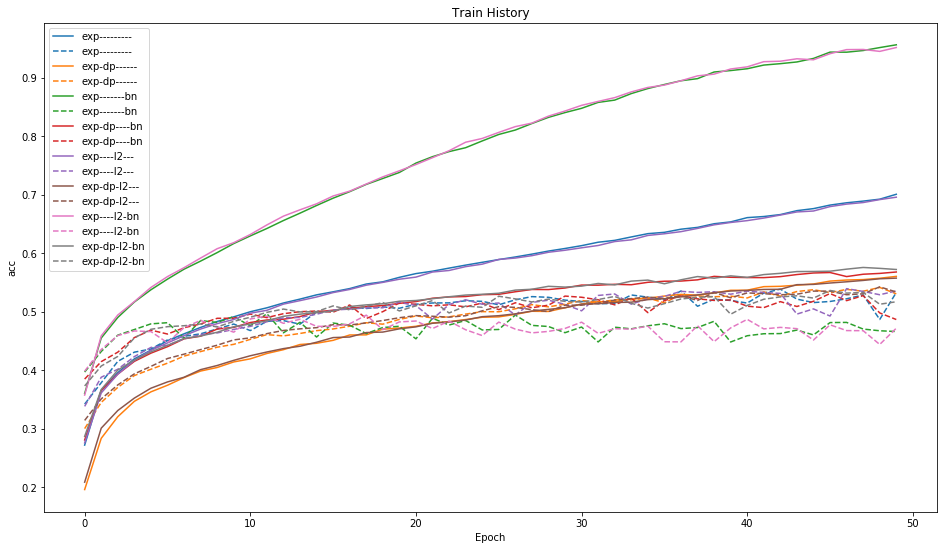

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, build_params)

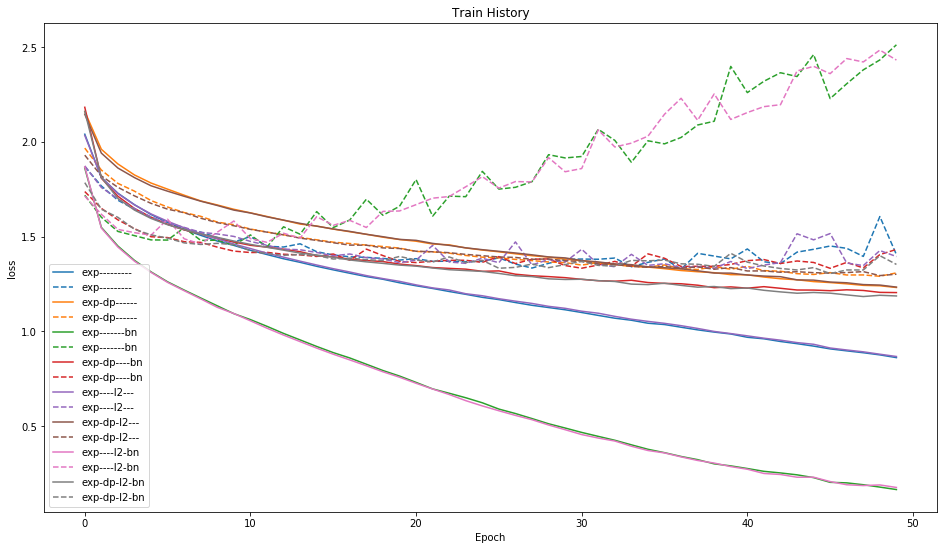

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, build_params)